In [1]:
import os
os.environ["TRANSFORMERS_OFFLINE"] ="1"
os.environ["TRANSFORMERS_CACHE"] = "/home/gridsan/groups/maia_mechint/models"

In [2]:
cd ../

/home/gridsan/cguo/rep_e_icl/rep_e_icl


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from repe import repe_pipeline_registry
repe_pipeline_registry()
from tasks import get_task_dataset
from modules import *

In [4]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=('llama' in model_name_or_path)).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=('llama' in model_name_or_path))
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [ ]:
import os
import tqdm
dataset_directions = {}

for dataset_name in tqdm.tqdm(os.listdir('data')):

# dataset_name = 'rotten_tomatoes'
    positive_prompt = "Pay attention to the following examples."
    negative_prompt = "Don't pay attention to the following exmaples."
    ntrain = 64 
    test_num_examples = 2
    user_tag = "[INST]"
    assistant_tag = "[/INST]"
    dataset = get_task_dataset(dataset_name, tokenizer, positive_prompt, negative_prompt, ntrain=ntrain, test_num_examples=test_num_examples)
    rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)
    rep_reader = get_rep_reader(model, rep_reading_pipeline, dataset)
    dataset_directions[dataset_name] = rep_reader.directions
    

    

In [11]:
import pickle
with open('directions_pca_mistral.pickle', 'wb') as f:
    pickle.dump(dataset_directions, f)

In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10)
dataset_data = []
for k,dirs in dataset_directions.items():
    dataset_data.append(np.concatenate([v for k,v in dirs.items()], axis=0))


transformed_data = tsne.fit_transform(np.concatenate(dataset_data, axis=0))


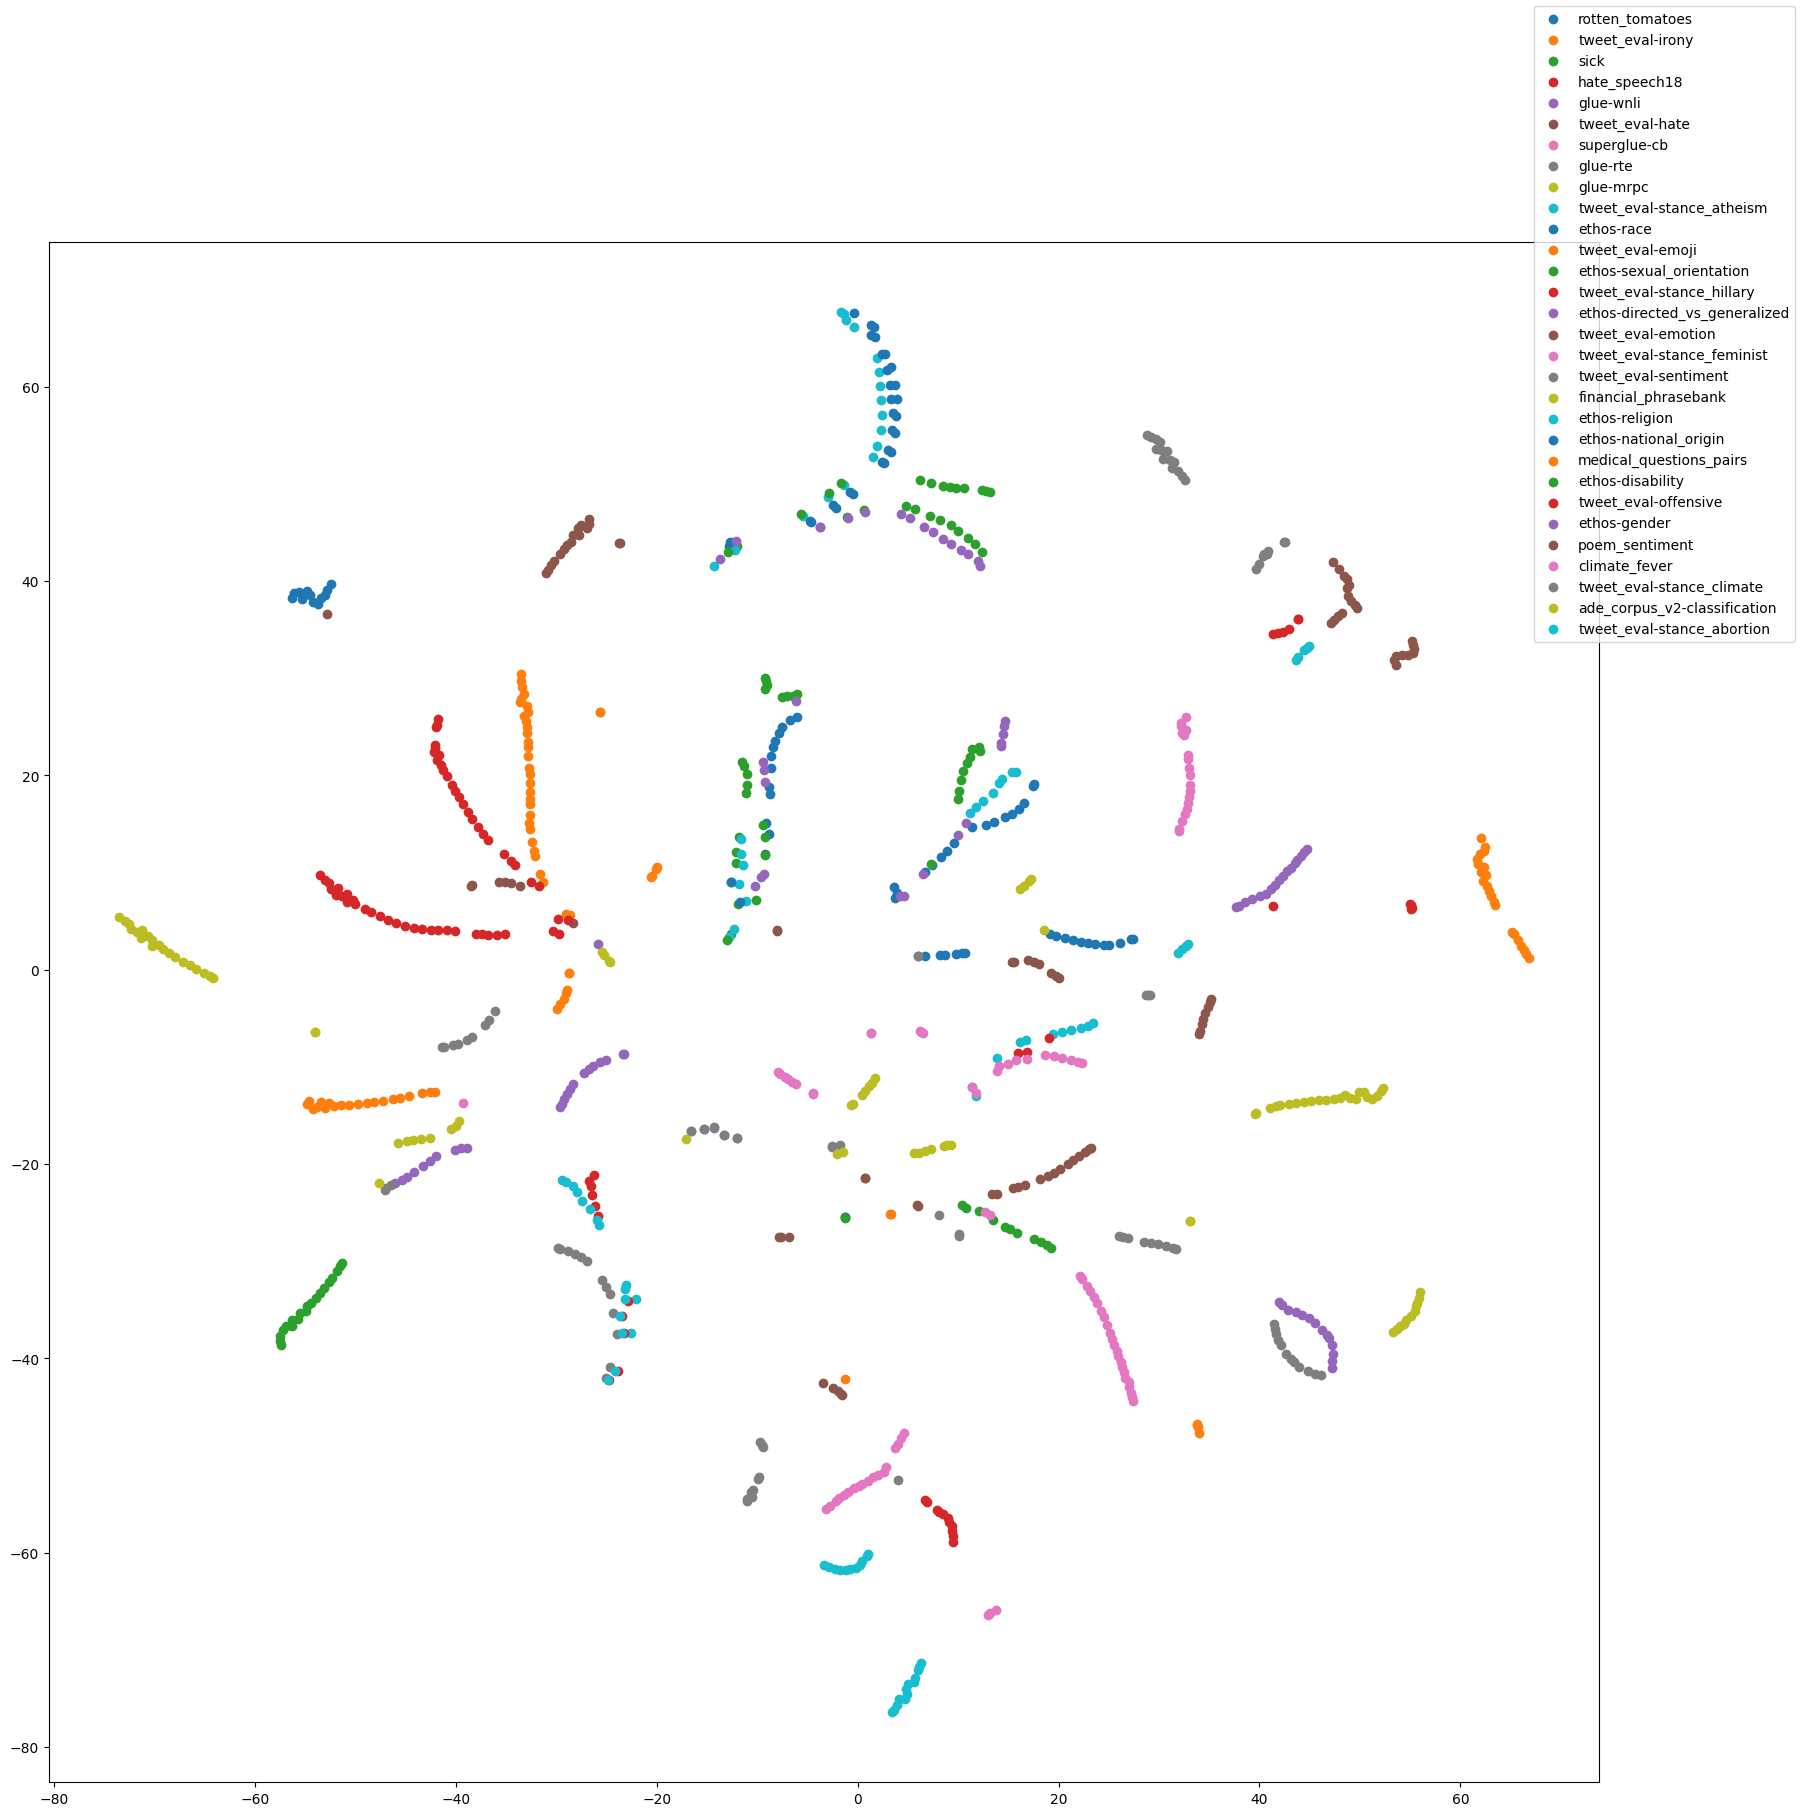

In [32]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(20,20))
sz = 0
for k,dirs in dataset_directions.items():
    
    ax.scatter(transformed_data[sz:sz+len(dirs), 0], transformed_data[sz:sz+len(dirs), 1], label=k)
    sz += len(dirs)

fig.legend()

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=10)
layers_data = []
for layer in hidden_layers:
    layers_data.append(np.concatenate( [ dirs[layer] for k,dirs in dataset_directions.items()], axis=0))


transformed_data = tsne.fit_transform(np.concatenate(layers_data, axis=0))


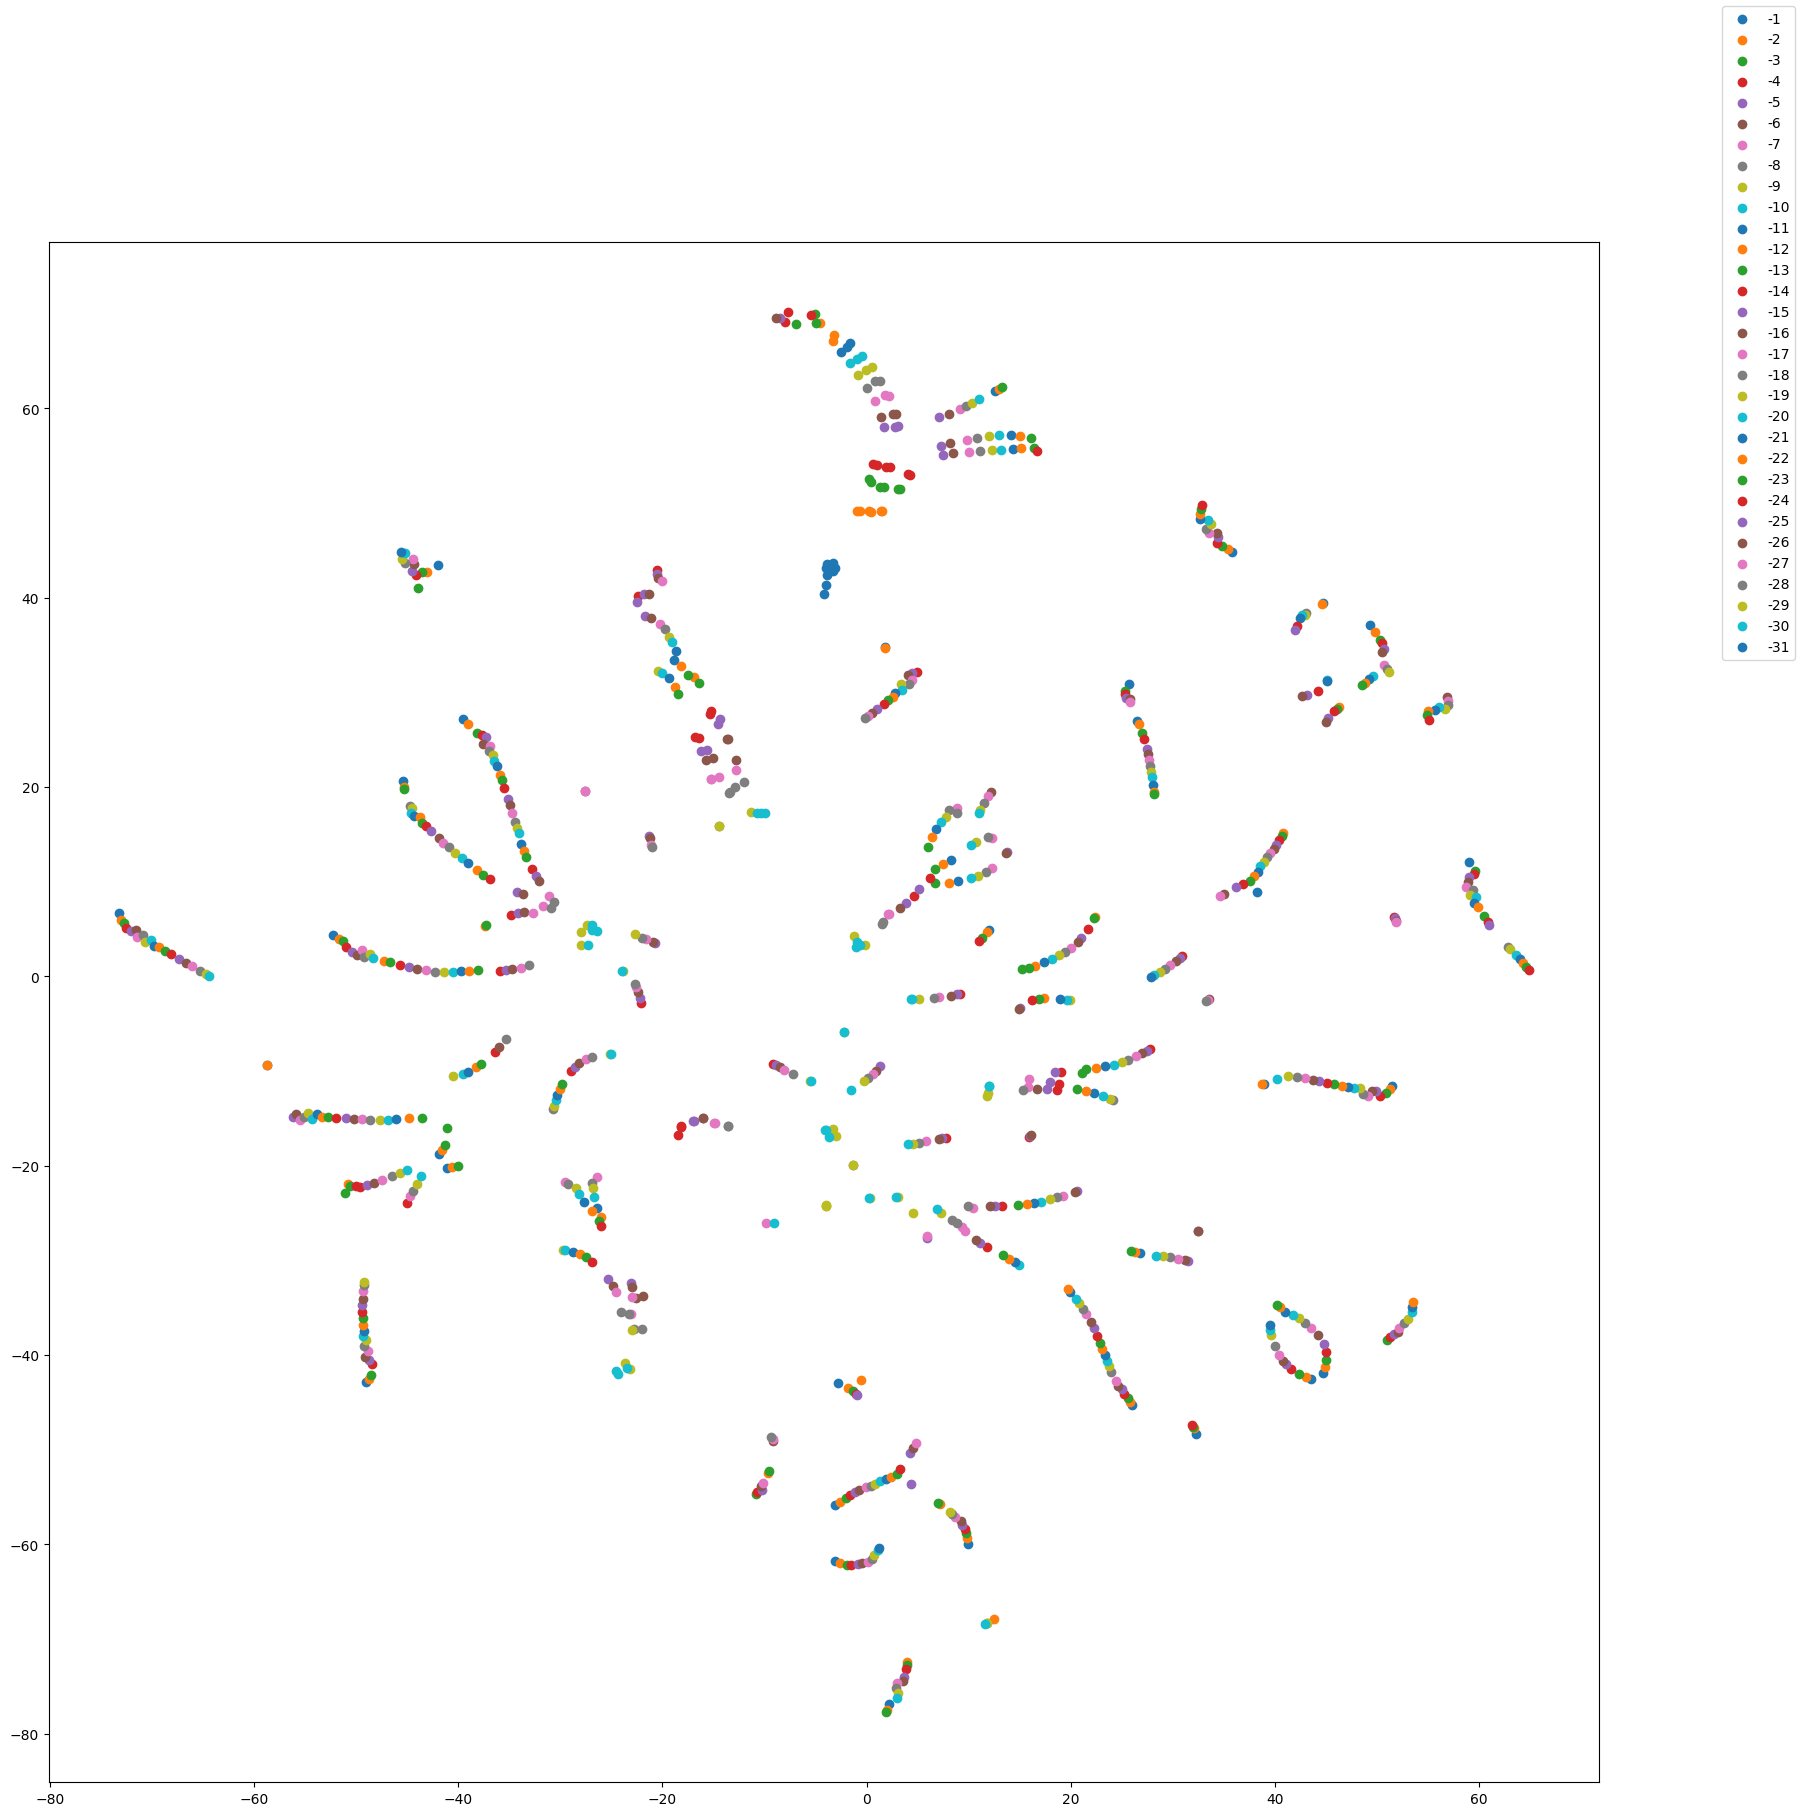

In [36]:

import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(20,20))
sz = 0
for layer, data in zip(hidden_layers, layers_data):
    
    ax.scatter(transformed_data[sz:sz+len(data), 0], transformed_data[sz:sz+len(data), 1], label=layer)
    sz += len(dirs)

fig.legend()

In [18]:
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)
rep_reader = get_rep_reader(model, rep_reading_pipeline, dataset)

["[INST] Don't pay attention to the following exmaples. [/INST] too silly to be frightening , too stolid to be funny , it projects the same lazy affability as its nominal star , david arquette .\nnegative\noften hilarious , well-shot and , importantly , entertaining , hell house is a fascinating document of an event that has to be seen to be believed .\npositive\n", "[INST] Pay attention to the following examples. [/INST] it's pretentious in a way that verges on the amateurish .\nnegative\nana is a vivid , vibrant individual and the movie's focus upon her makes it successful and accessible .\npositive\n", "[INST] Don't pay attention to the following exmaples. [/INST] manages to be wholesome and subversive at the same time .\npositive\nclint eastwood's blood work is a lot like a well-made pb& j sandwich : familiar , fairly uneventful and boasting no real surprises \x96 but still quite tasty and inviting all the same .\npositive\n", '[INST] Pay attention to the following examples. [/INST

In [11]:
dataset["test"]["data"]

['[INST] [/INST] compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .\npositive\nthe soundtrack alone is worth the price of admission .\n',
 "[INST] [/INST] rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .\npositive\nbeneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .\n",
 "[INST] [/INST] bielinsky is a filmmaker of impressive talent .\npositive\nso beautifully acted and directed , it's clear that washington most certainly has a new career ahead of him if he so chooses .\n",
 '[INST] [/INST] a visual spectacle full of stunning images and effects .\npositive\na gentle and engrossing character study .\n',
 "[INST] [/INST] it's enough to watch huppert scheming , with her small , intelligent eyes as steady as any noir villain , and to

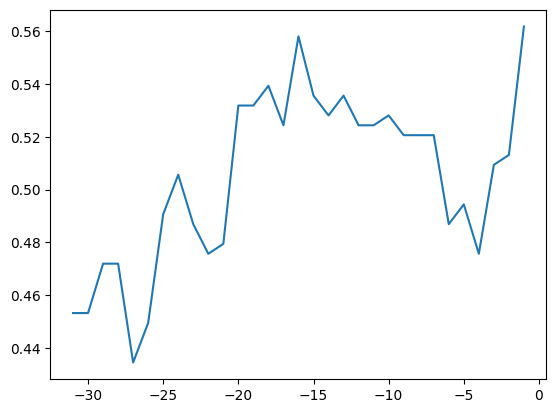

In [19]:
hidden_layers = get_hidden_layers(model)
H_tests = get_h_test(
    model, 
    rep_reading_pipeline, 
    rep_reader, 
    dataset
)
plot_correlation(rep_reader, H_tests, hidden_layers)

In [21]:
data = dataset["test"]["data"][1]
test_data = get_test_data(model, tokenizer, [data])
wanted_layers = range(-10, -25, -1)
rep_reader_scores_dict, rep_reader_scores_mean_dict = get_rep_reader_scores_dict(model, tokenizer, 
                                                                                 rep_reading_pipeline, 
                                                                                 rep_reader, 
                                                                                 test_data, wanted_layers=wanted_layers )

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [23]:
THRESHOLD = 0.0 # change this to alter sensitivity
input_ids = tokenizer.tokenize(test_data[0])

4 (103, 31)


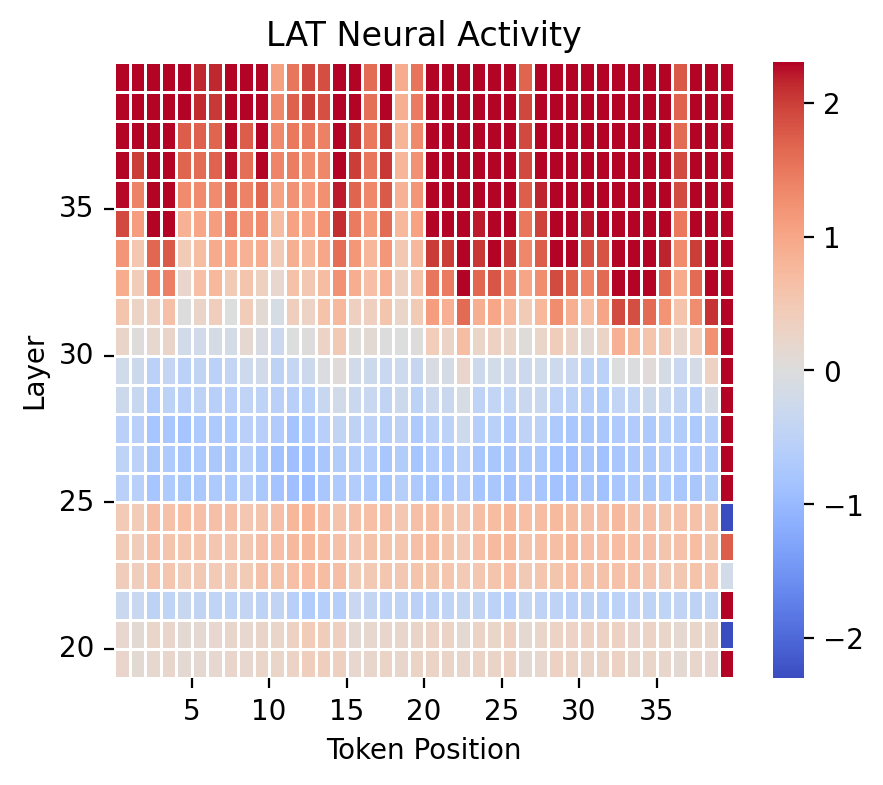

In [27]:
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(5, -5))

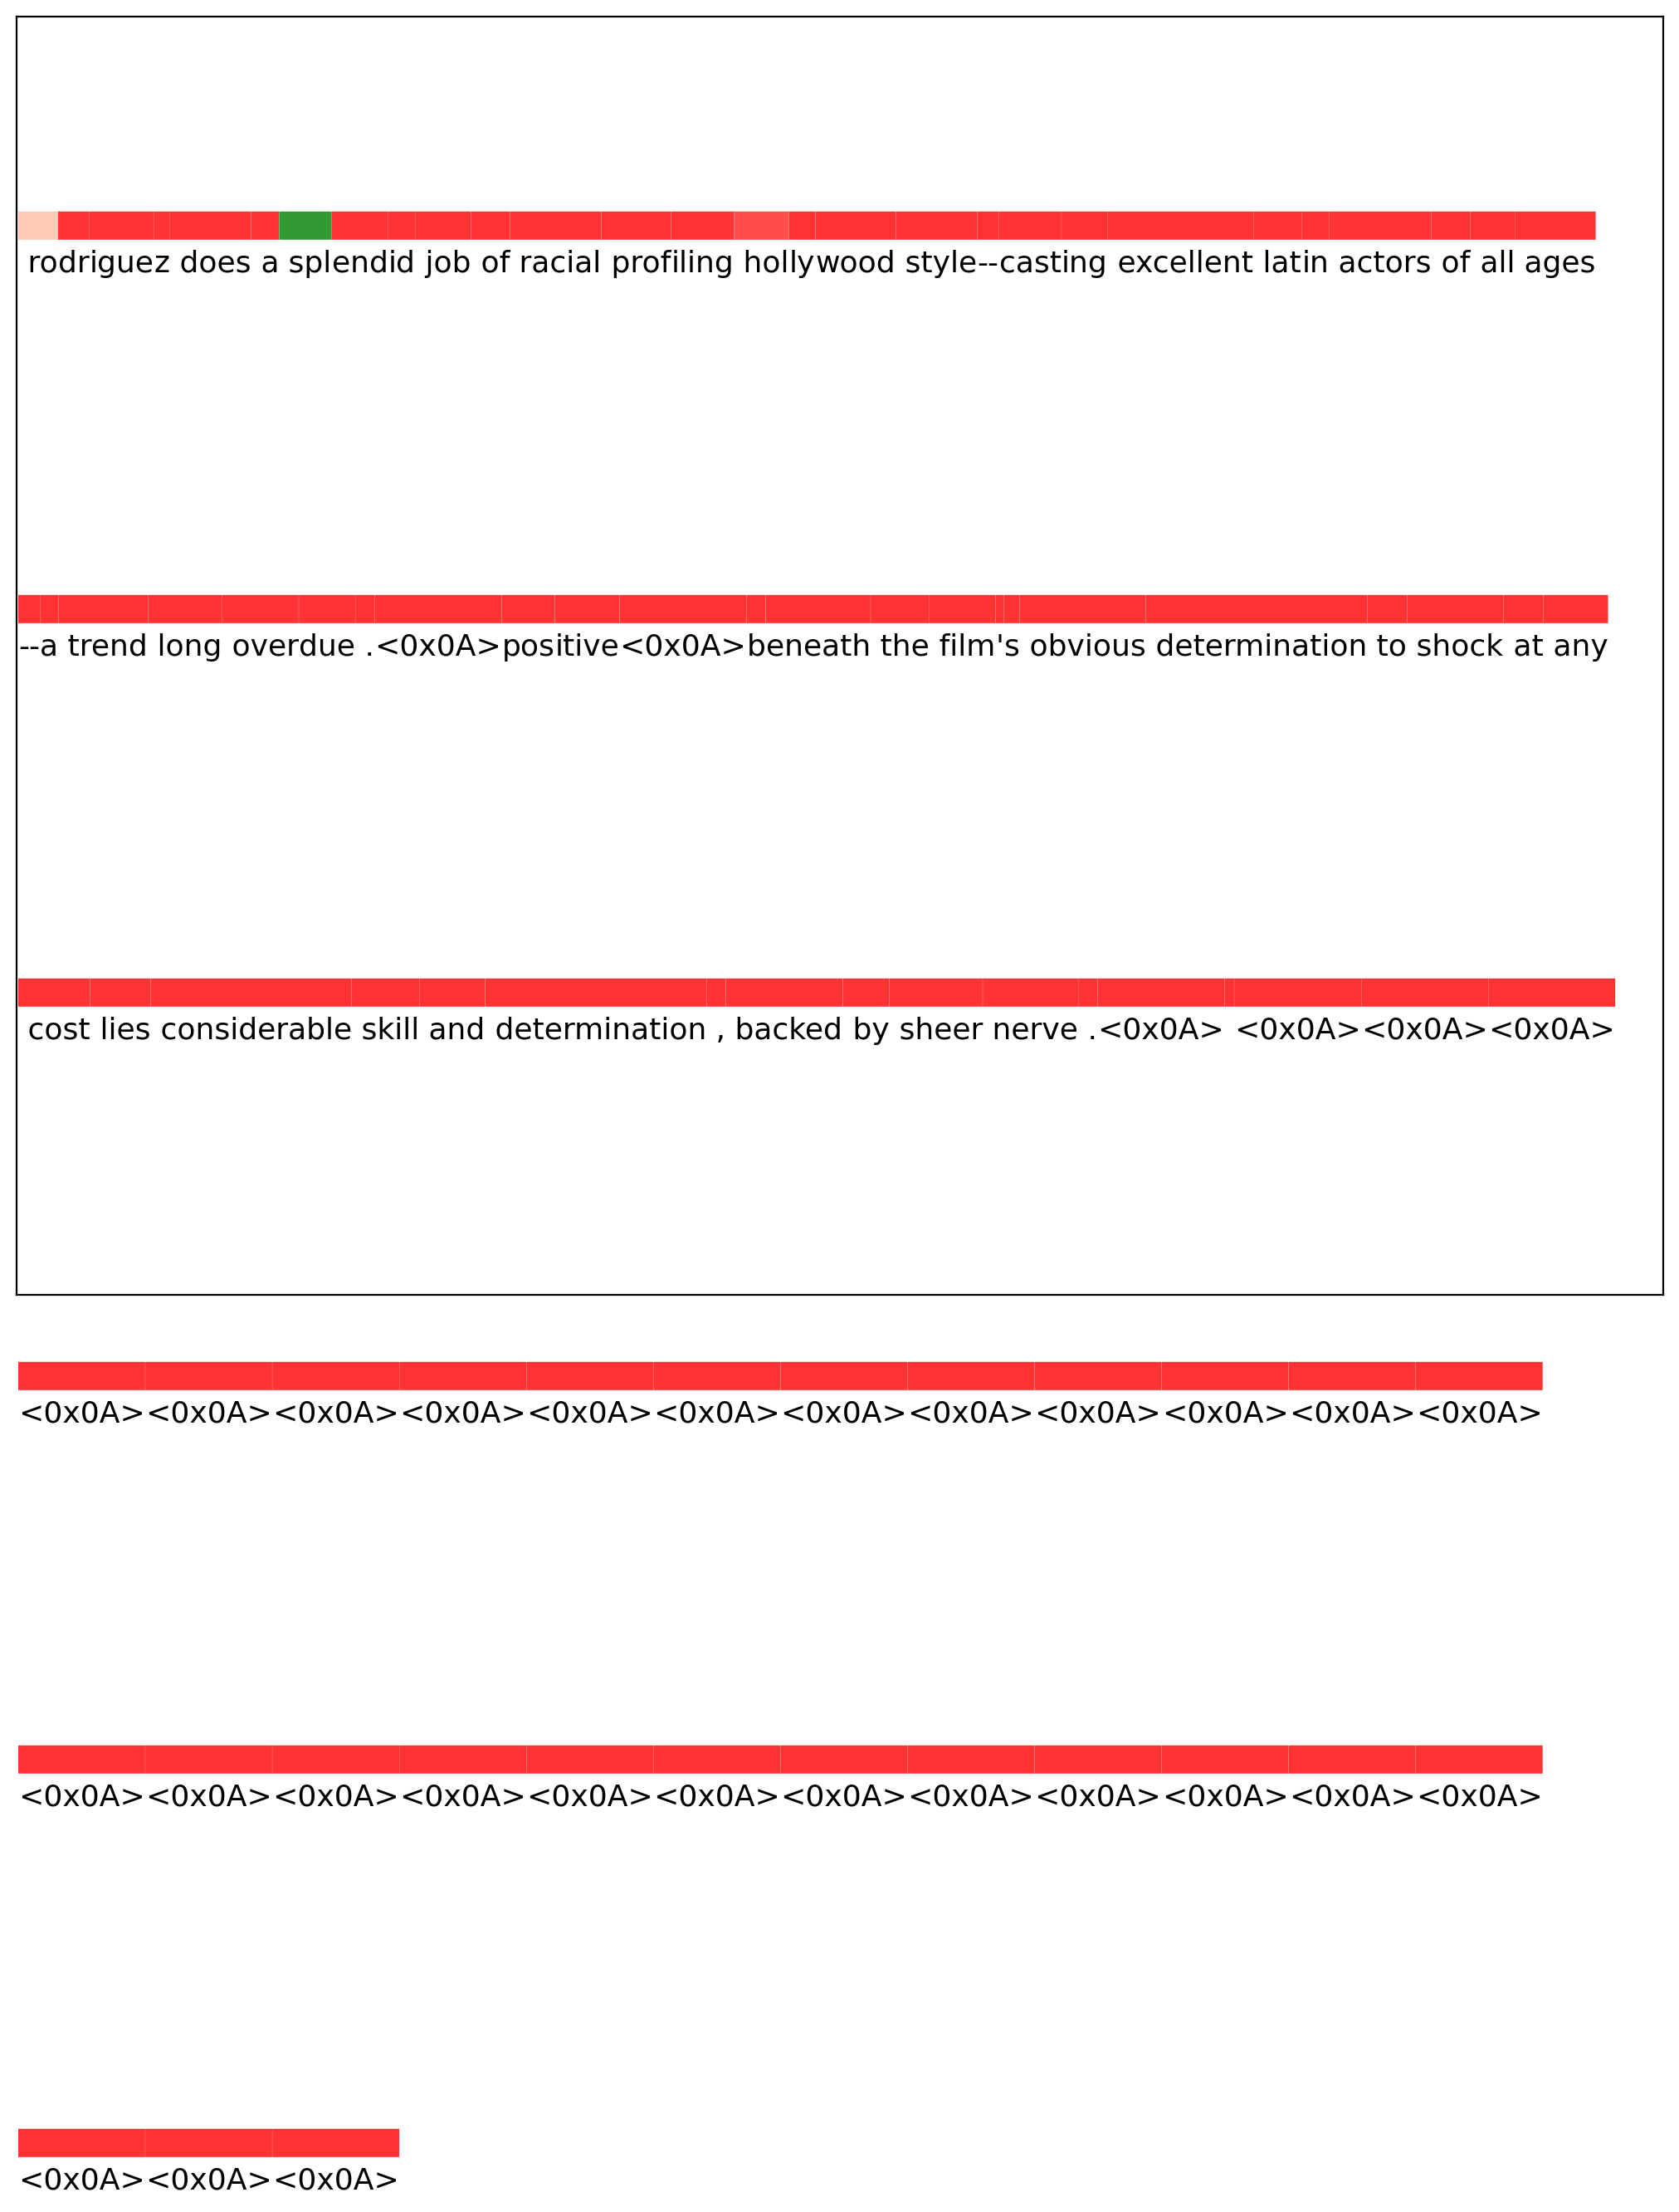

In [28]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

In [29]:

max_layer = -10
min_layer = -25

layer_id = list(range(max_layer, min_layer, -1))
rep_control = get_rep_control(model, tokenizer, layer_id)

In [54]:
test_dataset_name = 'ade_corpus_v2-classification'
# test_dataset_name = 'rotten_tomatoes'
test_positive_prompt = "Pay attention to the following examples."
test_negative_prompt = "Don't pay attention to the following exmaples."
ntrain = 64 
test_num_examples = 2
test_dataset_len = 16
user_tag = "[INST]"
assistant_tag = "[/INST]"
test_dataset = get_task_dataset(test_dataset_name, tokenizer, positive_prompt, negative_prompt, ntrain=ntrain, test_num_examples=test_num_examples)
test_dataset['test']['data'] = test_dataset['test']['data'][:test_dataset_len]
test_dataset['test']['labels'] = test_dataset['test']['labels'][:test_dataset_len]


getting dataset for ade_corpus_v2-classification
['Not Related', 'Related']
data len: 32
['Not Related', 'Related']
data len: 32
['Not Related', 'Related']
data len: 2352


In [56]:

baseline, pos_results, neg_results = get_rep_controlled_results(rep_reader, rep_control, test_dataset["test"]["data"], layer_id)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Done with baseline results!


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Done with control outputs!


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Done with neg control outputs


In [61]:
test_dataset["test"]["data"]

['[INST] [/INST] Pemphigus vulgaris (PV) is a rare but potentially fatal autoimmune bullous disorder which frequently affects the oral mucosa.\nNot Related\nThe clinical course suggests that caffeine, which is present in oolong tea, was mainly responsible for the rhabdomyolysis as well as the delirium, although severe hyponatremia has been reported to cause rhabdomyolysis on rare occasions.\n',
 '[INST] [/INST] Tardive oculogyric crisis (OGC) is a dystonic syndrome that starts after long-term use of dopamine receptor antagonists.\nNot Related\nA new sodium homoeostasis was established with a higher dose of DDAVP.\n',
 '[INST] [/INST] 2). These findings were characteristic of granular parakeratosis.\nNot Related\nThree patients receiving gold salt treatment for rheumatoid arthritis developed severe aplastic anemia.\n',
 '[INST] [/INST] Radiation enteritis: a rare complication of the transverse colon in uterine cancer.\nNot Related\nCase report: acute renal failure after administering in

In [58]:
test_dataset['test']['labels']

['Related',
 'Not Related',
 'Related',
 'Related',
 'Not Related',
 'Not Related',
 'Not Related',
 'Not Related',
 'Not Related',
 'Related',
 'Related',
 'Not Related',
 'Not Related',
 'Related',
 'Not Related',
 'Not Related']

In [59]:
acc_dict = get_acc_dict(baseline, pos_results, neg_results, test_dataset["test"]["labels"])

Here are
The purpose
### Con
"I
The patient
The patient
```
After administer
The patient
###
The patient
###
The use
The patient
After the
The patient


In [60]:
acc_dict

{'baseline_acc': 0.062, 'pos_acc': 0.0, 'neg_acc': 0.0}

In [62]:
for a, b, c in zip(baseline, pos_results, neg_results): 
    print(a, b, c)
    print("-----")

The film Here are the film
-----
A new The purpose dont
-----
Not Related ### Con Not related to
-----
# "I not related to
-----
# The patient #
-----
It is The patient It is
-----
# ``` #
-----
this is After administer this is a
-----
this is The patient this is
-----
Crap ### Crap
-----
20 The patient 20
-----
Pot ### #
-----
Hep The use Hep
-----
this is the The patient this is the
-----
the l After the the worst
-----
Another The patient Another
-----
